In [30]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
%env XLA_PREALLOCATEXLA_PYTHON_CLIENT_PREALLOCATE=false
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
from PIL import Image

env: XLA_PREALLOCATEXLA_PYTHON_CLIENT_PREALLOCATE=false


In [241]:
# Hyperparameters

BATCH_SIZE = 64*2
LEARNING_RATE = 3e-4
STEPS = 1000 
PRINT_EVERY = 30
SEED = 5678

key = jax.random.PRNGKey(SEED)

In [242]:
from annotation_schema import CroppedDatasetImage,UnannotatedImage,CroppedImageLabel,CroppedImage

Get median point

In [243]:
import pandas as pd

def get_labeled_dataset():
    fnames,labels = ( CroppedImageLabel).fetch('fname','y')
    labels = np.stack(labels).squeeze()
    manual_df = pd.DataFrame({'l0':labels[:,0],'l1':labels[:,1],'l2':labels[:,2],'l3':labels[:,3],'fname':fnames})
    y = manual_df.groupby('fname').median().values
    xnames = manual_df.groupby('fname').median().index
    X = []
    for fname in xnames:
        X.append((CroppedImage & {'fname':fname}).fetch1('image_cropped'))
    X = np.stack(X)
    assert X.shape[0] == y.shape[0]
    return X,y

In [244]:
import os
import pandas as pd
from torch.utils.data import Dataset

def target_transform(label):
    return torch.tensor(label)

normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

from torchvision import transforms

# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert images to tensors
#     # transforms.Resize((256, 256)),  # Resize images to 256x256
#     # transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
#     # transforms.RandomVerticalFlip(),  # Randomly flip images vertically
#     transforms.RandomApply([  # Apply the following transforms randomly
#         transforms.ColorJitter(brightness=0.5, contrast=0.5),
#         # transforms.RandomRotation(degrees=45),
#     ], p=0.8),  # Apply the above transforms with 50% probability
#     transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
#     transforms.Normalize((0.5),(0.5)),
#     transforms.RandomErasing(p=0.8, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
# ])
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    # transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    # transforms.RandomApply([  # Apply the following transforms randomly
    #     transforms.ColorJitter(brightness=0.5, contrast=0.5),
    #     # transforms.RandomRotation(degrees=45),
    # ], p=0.8),  # Apply the above transforms with 50% probability
    transforms.Normalize((0.5),(0.5)),
    # transforms.RandomErasing(p=0.8, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
])


class EyeDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        X,y = get_labeled_dataset()
        Xl,yl = CroppedDatasetImage.fetch('image_cropped','y_cropped')
        Xl = np.stack(Xl)
        yl = np.vstack(yl).astype(np.float32)
        X = np.concatenate([X,Xl])
        y = np.concatenate([y,yl])
        self.img_labels = y
        self.images = X
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels[idx]
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [245]:
from torch.utils.data import DataLoader, random_split

In [246]:
eye_dataset = EyeDataset(transform=transform, target_transform=target_transform)
train_size = int(0.8 * len(eye_dataset))  # 80% of the dataset for training
test_size = len(eye_dataset) - train_size  # The rest for testing
train_dataset, test_dataset = random_split(eye_dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

eye_dataset.

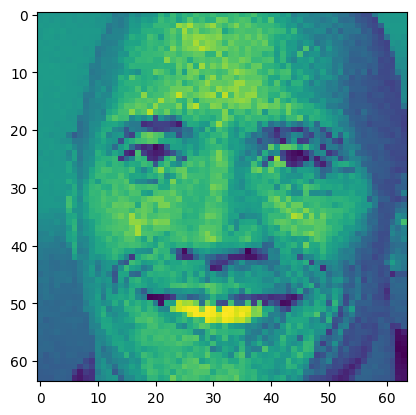

In [247]:
plt.figure()
plt.imshow(eye_dataset[6][0][0])

In [248]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4, key5, key6 = jax.random.split(key, 6)
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, stride=1, key=key1),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=3),
            jnp.ravel,
            # Adjusted size based on new conv/pooling layers
            eqx.nn.Linear(10443, 2148, key=key3),  # Placeholder, adjust based on actual size
            jax.nn.sigmoid,
            eqx.nn.Linear(2148, 512, key=key4),
            jax.nn.relu,
            eqx.nn.Linear(512, 64, key=key5),
            jax.nn.relu,
            eqx.nn.Linear(64, 4, key=key6),
            jax.nn.sigmoid
        ]
        # self.layers = [
        #     eqx.nn.Conv2d(1, 16, kernel_size=4, stride=1, padding=1, key=key1),  # More filters for the first conv layer
        #     jax.nn.relu,
        #     eqx.nn.MaxPool2d(kernel_size=2, stride=2),  # Standard pool size and stride
            
        #     eqx.nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1, key=key2),  # Increase filters, adjust kernel size/stride as needed
        #     jax.nn.relu,
        #     eqx.nn.MaxPool2d(kernel_size=2, stride=2),
            
        #     # You might want to add one more Conv and Pool if needed
        #     # eqx.nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1, key=key3),
        #     # jax.nn.relu,
        #     # eqx.nn.MaxPool2d(kernel_size=2, stride=2),
            
        #     jnp.ravel,  # Flatten the output of the last pooling layer

        #     # Fully connected layers
        #     # The number of input features to this layer must match the flattened output from the last pooling layer
        #     eqx.nn.Linear(7200, 256, key=key4),  # The input size 'XXXX' needs to be calculated
        #     jax.nn.relu,
            
        #     eqx.nn.Linear(256, 64, key=key5),
        #     jax.nn.relu,
            
        #     eqx.nn.Linear(64, 4, key=key6),
        #     jax.nn.sigmoid,  # Use tanh for output to match the -1 to 1 range
        # ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        # return x + jnp.array((384, 286, 384., 286.))/2
        return x * 64.


key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

In [249]:
def loss(
    model: CNN, x: Float[Array, "batch 1 64 64"], y: Int[Array, "batch 4"]
) -> Float[Array, ""]:

    pred_y = jax.vmap(model)(x)
    return optax.l2_loss(y, pred_y).mean()

loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!

@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch 1 64 64"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = jax.vmap(model)(x)
    return jnp.mean(jnp.abs(pred_y - y))

In [250]:
optim = optax.adamw(LEARNING_RATE)

In [264]:
def train(
    model: CNN,
    trainloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
) -> CNN:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader
    
    def infinite_testloader():
        while True:
            yield from testloader

    lossl=[]
    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        x_test, y_test = next(infinite_testloader())
        x_test = x_test.numpy()
        y_test = y_test.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            mean_pixel_error = compute_accuracy(model, x_test, y_test)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_accuracy={mean_pixel_error}"
            )
        if (step % 100) == 0:
            evalx,yhat = eye_dataset[10]
            pred = model(evalx.numpy()).squeeze()
            plt.figure()
            plt.imshow(evalx.squeeze())
            y = pred.reshape(-1,2)
            plt.scatter(y[:,0],y[:,1],c='r')
            plt.scatter(yhat[0],yhat[1],c='b')
            plt.scatter(yhat[2],yhat[3],c='b')
        lossl.append(train_loss.item())
    return model,lossl

step=0, train_loss=91.80534362792969, test_accuracy=4.048251628875732
step=30, train_loss=16.90858268737793, test_accuracy=1.992647647857666
step=60, train_loss=27.56367301940918, test_accuracy=1.8243999481201172
step=90, train_loss=30.757795333862305, test_accuracy=1.8322522640228271
step=120, train_loss=89.98706817626953, test_accuracy=1.8310446739196777
step=150, train_loss=66.00023651123047, test_accuracy=1.844372034072876
step=180, train_loss=65.5615234375, test_accuracy=1.8521571159362793
step=210, train_loss=25.085237503051758, test_accuracy=1.8333535194396973
step=240, train_loss=53.34657287597656, test_accuracy=1.861522912979126
step=270, train_loss=130.346435546875, test_accuracy=1.8601431846618652
step=300, train_loss=129.17080688476562, test_accuracy=1.8467285633087158
step=330, train_loss=301.67449951171875, test_accuracy=1.8450355529785156
step=360, train_loss=155.14712524414062, test_accuracy=1.8827873468399048
step=390, train_loss=60.07207489013672, test_accuracy=1.8367

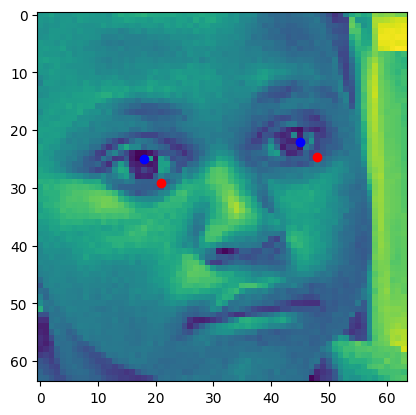

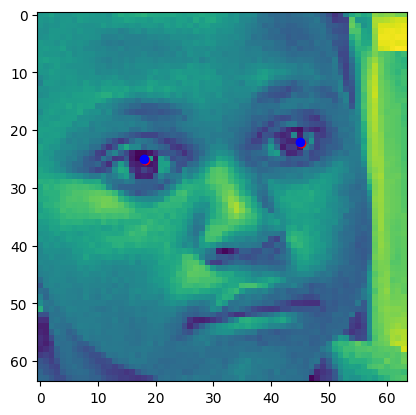

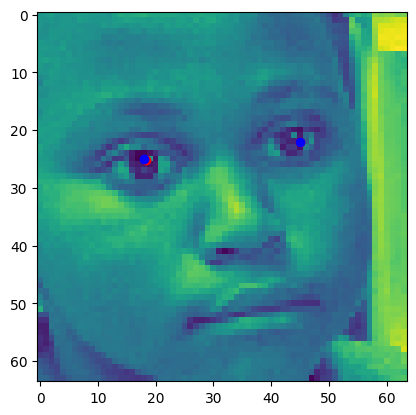

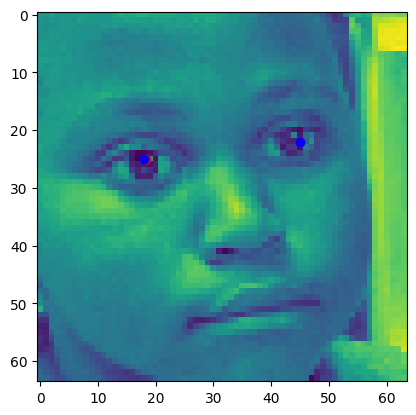

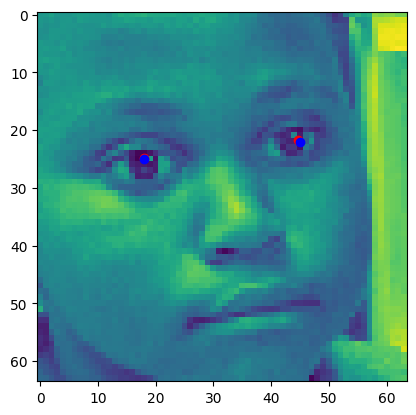

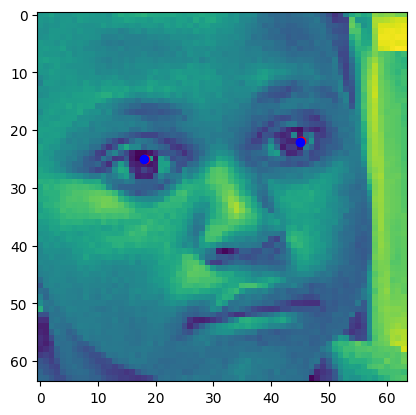

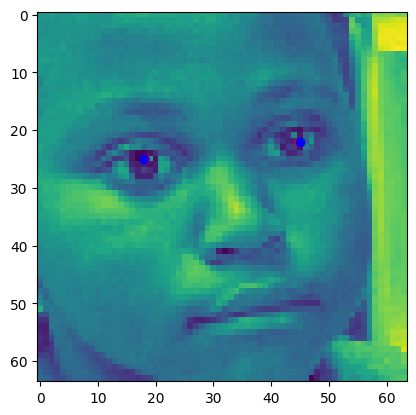

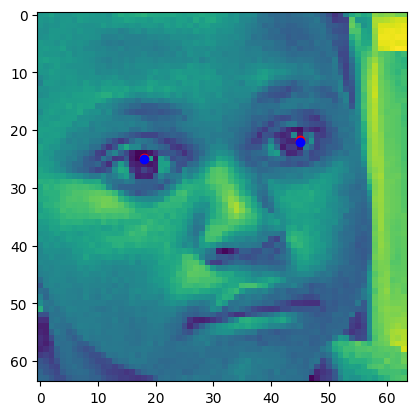

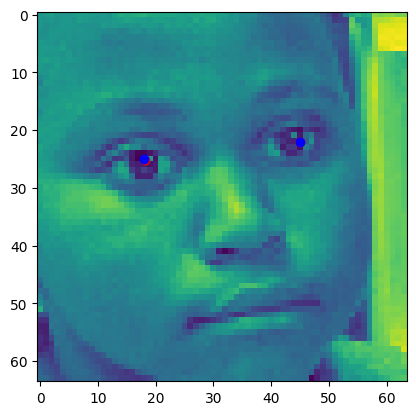

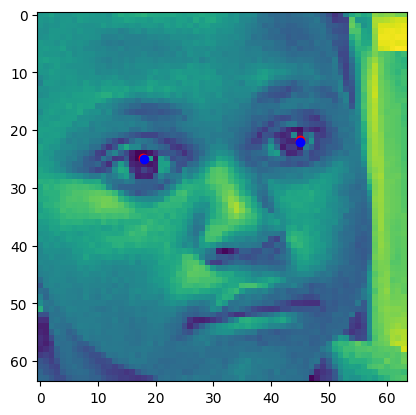

In [265]:
model,loss_list = train(model, trainloader, optim, STEPS, PRINT_EVERY)

Text(0, 0.5, 'Error')

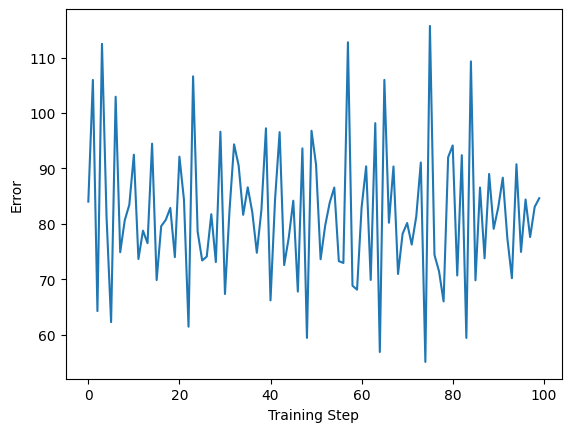

In [266]:
plt.figure()
pp = np.array(loss_list).reshape(-1,10).mean(axis=1)
plt.plot(pp)
plt.xlabel('Training Step')
plt.ylabel("Error")

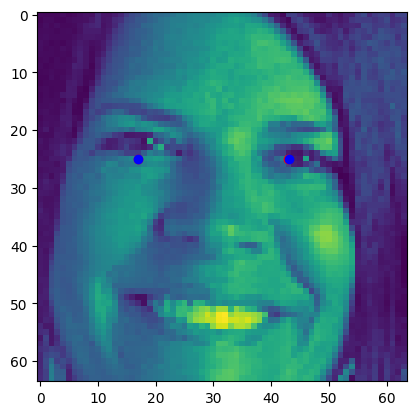

In [267]:
x,y = eye_dataset[1]
x = x.numpy()
y=y.numpy()
pred = model(x)
plt.figure()
plt.imshow(x.squeeze())
plt.scatter(pred[0], pred[1], c='r')
plt.scatter(pred[2], pred[3], c='r')
plt.scatter(y[0], y[1], c='b')
plt.scatter(y[2], y[3], c='b')

In [1]:
import cv2
image_path = 'dwaynejohnson.jpg'
img = cv2.imread(image_path)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Convert the image to grayscale - Haar Cascades require grayscale images
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Display the output
cv2.imshow('Face Detection', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
import cv2

img = cv2.imread('dwaynejohnson.jpg')

# Convert the image to grayscale - Haar Cascades require grayscale images
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Assume you have some points you want to transform for the first detected face
original_points = [(232, 110)] # Replace with your actual points

for index, (x, y, w, h) in enumerate(faces):
    # Crop and resize the face
    face_img = gray[y:y+h, x:x+w]
    resized_face = cv2.resize(face_img, (64, 64))
    
    # Save the resized face
    cv2.imwrite(f'face_{index}.png', resized_face)
    
    # Calculate new points positions for the resized image
    scaled_points = [(int((xp - x) * 64 / w), int((yp - y) * 64 / h)) for (xp, yp) in original_points]
    

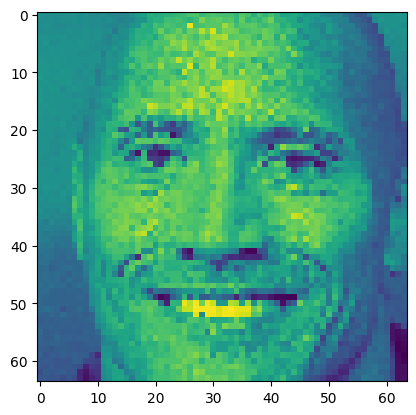

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(resized_face)


In [19]:
x,y,w,h = faces[0]

In [20]:
x

1094

In [16]:
faces.shape[0] == 1

True

In [5]:
scaled_points

NameError: name 'scaled_points' is not defined

In [ ]:
pred[]